<h1 align="center">A/B Test Simulation and Analysis</h1>

# 1. Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# 2. Data Simulation

In this section, we'll create synthetic data that represents a typical A/B test scenario. Here we simulate:
- Two groups: control (existing version) and treatment (new version)
- 10,000 users in each group
- Binary outcome: conversion (1) or no conversion (0)
- Control group has a 10% conversion rate
- Treatment group has a 11% conversion rate (a 1% absolute improvement)

In [2]:
# Simulation parameters
n = 10000  # users per group
p_control = 0.10  # 10% conversion in control
p_treatment = 0.11  # 11% conversion in treatment

# Generate random binary outcomes using binomial distribution
control = np.random.binomial(1, p_control, n)
treatment = np.random.binomial(1, p_treatment, n)

# Create a dataframe to store the results
data = pd.DataFrame({
    'group': ['control'] * n + ['treatment'] * n,
    'converted': np.concatenate([control, treatment])
})

# Display the first few rows of the dataframe
data.head()

,group,converted
0,control,0
1,control,1
2,control,0
3,control,0
4,control,0


In [3]:
# Save data to CSV file
os.makedirs("../data", exist_ok=True)
data.to_csv('../data/synthetic_ab_test.csv', index=False)

# 3. Statistical Analysis

## 3.1. Manual Hypothesis Testing

Now we'll conduct a hypothesis test to determine if the difference between the treatment and control groups is statistically significant.

Our hypotheses are:
- **Null Hypothesis (H₀)**: There is no difference between control and treatment (δ = 0)
- **Alternative Hypothesis (H₁)**: There is a difference between control and treatment (δ ≠ 0)

We'll use a two-proportion z-test, which is appropriate for comparing binary outcomes between two groups.

In [4]:
# Calculate the mean (proportion) for each group
mean_control = control.mean()
mean_treatment = treatment.mean()
delta = mean_treatment - mean_control

# Calculate pooled proportion and standard error
p_pooled = (control.sum() + treatment.sum()) / (2 * n)
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * 2 / n)

# Calculate z-score and p-value
z_score = delta / se_pooled
p_value_manual = 2 * (1 - stats.norm.cdf(np.abs(z_score)))

print(f"Control conversion rate: {mean_control:.4f}")
print(f"Treatment conversion rate: {mean_treatment:.4f}")
print(f"Absolute lift: {delta:.4f} ({delta/mean_control*100:.2f}% relative lift)")
print(f"Z-score: {z_score:.4f}")
print(f"p-value (manual calculation): {p_value_manual:.4f}")

Control conversion rate: 0.0961
Treatment conversion rate: 0.1130
Absolute lift: 0.0169 (17.59% relative lift)
Z-score: 3.9056
p-value (manual calculation): 0.0001


## 3.2. Validation with SciPy

To verify our manual calculations, we'll use SciPy's implementation of the t-test. For large samples, the t-test and z-test give very similar results.

In [5]:
# Use SciPy's t-test to validate our manual calculation
_, p_value_scipy = stats.ttest_ind(treatment, control)
print(f"p-value (scipy t-test): {p_value_scipy:.4f}")

# Determine statistical significance
alpha = 0.05
if p_value_manual < alpha:
    print(f"The result is statistically significant at α = {alpha}")
    if delta > 0:
        print("The treatment performs better than the control")
    else:
        print("The control performs better than the treatment")
else:
    print(f"The result is not statistically significant at α = {alpha}")

p-value (scipy t-test): 0.0001
The result is statistically significant at α = 0.05
The treatment performs better than the control


## 3.3. Confidence Interval

A confidence interval provides a range of plausible values for the true difference between groups. A 95% confidence interval means that if we repeated the experiment many times, 95% of the intervals would contain the true difference.

In [6]:
# Calculate 95% confidence interval
ci_low = delta - 1.96 * se_pooled
ci_high = delta + 1.96 * se_pooled

print(f"95% Confidence Interval for lift: ({ci_low:.4f}, {ci_high:.4f})")

# Interpretation
if ci_low > 0:
    print("Since the entire confidence interval is positive, we're 95% confident that the treatment improves conversion rate")
elif ci_high < 0:
    print("Since the entire confidence interval is negative, we're 95% confident that the treatment reduces conversion rate")
else:
    print("Since the confidence interval contains zero, we cannot be 95% confident about the direction of the effect")

95% Confidence Interval for lift: (0.0084, 0.0254)
Since the entire confidence interval is positive, we're 95% confident that the treatment improves conversion rate


# 4. Visualization

Visualization helps communicate the results effectively. We'll create a bar chart showing the conversion rates for each group along with their 95% confidence intervals.

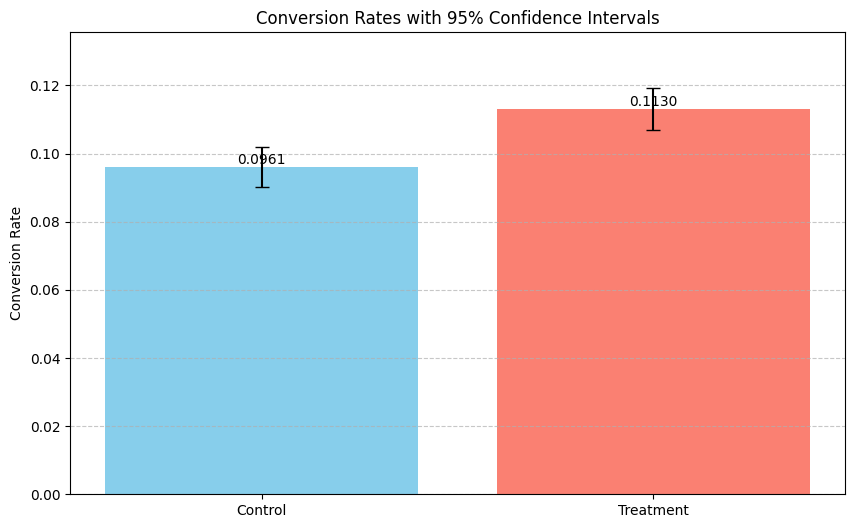

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(['Control', 'Treatment'], [mean_control, mean_treatment],
        yerr=[1.96 * np.sqrt(mean_control * (1 - mean_control) / n),
              1.96 * np.sqrt(mean_treatment * (1 - mean_treatment) / n)],
        capsize=5, color=['skyblue', 'salmon'])
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% Confidence Intervals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(mean_control, mean_treatment) * 1.2)  # Add some space above the bars

# Add text annotations
plt.text(0, mean_control, f"{mean_control:.4f}", ha='center', va='bottom')
plt.text(1, mean_treatment, f"{mean_treatment:.4f}", ha='center', va='bottom')

# Save and display the figure
os.makedirs("../images", exist_ok=True)
plt.savefig('../images/conversion_bar_ci.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. False Positive Rate Simulation

The false positive rate (Type I error) is the probability of incorrectly rejecting the null hypothesis when it's actually true. We'll simulate this by running many A/B tests where there is no actual difference between groups.

In [8]:
def simulate_fpr(null_p=0.10, sims=1000, n=10000, alpha=0.05):
    """
    Simulate false positive rate by running multiple A/B tests where the null hypothesis is true.
    
    Parameters:
    -----------
    null_p : float
        The true conversion rate for both groups.
    sims : int
        Number of simulations to run.
    n : int
        Number of users in each group.
    alpha : float
        Significance level.
    
    Returns:
    --------
    float
        Proportion of simulations where null hypothesis was falsely rejected.
    """
    false_positives = 0
    
    for _ in range(sims):
        # Generate data with identical conversion rates
        ctrl = np.random.binomial(1, null_p, n)
        trt = np.random.binomial(1, null_p, n)
        
        # Run t-test
        _, pval = stats.ttest_ind(trt, ctrl)
        
        # Count false positives
        if pval < alpha:
            false_positives += 1
            
    return false_positives / sims

# Run the simulation
fpr = simulate_fpr()
print(f"Simulated False Positive Rate (α=0.05): {fpr:.3f}")
print(f"Expected False Positive Rate: 0.05")

# Run simulation with more iterations for better accuracy
fpr_more_sims = simulate_fpr(sims=5000)
print(f"Simulated False Positive Rate with 5000 simulations: {fpr_more_sims:.3f}")

Simulated False Positive Rate (α=0.05): 0.054
Expected False Positive Rate: 0.05
Simulated False Positive Rate with 5000 simulations: 0.046


# 6. Conclusion

In this notebook, we've simulated an A/B test and performed the necessary statistical analysis to determine if the treatment group performs significantly better than the control group.

Key findings:
1. The treatment group showed a 1% absolute improvement in conversion rate.
2. We calculated a p-value to evaluate statistical significance.
3. We determined a 95% confidence interval for the true lift.
4. We visualized the results with appropriate error bars.
5. We simulated the false positive rate to validate our statistical approach.

When conducting real A/B tests, it's important to:
- Define clear metrics before starting the test
- Ensure proper randomization of users
- Calculate the required sample size in advance
- Monitor the test for sufficient duration
- Consider practical significance along with statistical significance

A statistically significant result doesn't always mean a practically significant one - business context matters!